In [1]:
import numpy as np
import cv2
import glob
import os
from datetime import datetime as dt
import matplotlib.pyplot as plt
import math
from math import sin, cos, pi, radians, degrees, sqrt, atan2, ceil
import panorama_operations as pano

## rectify lens distortion

In [2]:
## estimated with checkerboard calibration
K = np.load('B036_intrintics.npy')
D = np.load('B036_distortion.npy')

In [3]:
## load 4 images
img_north =  cv2.imread('test_images/North_2022-02-09_160021_image.jpg')
img_south =  cv2.imread('test_images/South_2022-02-09_160030_image.jpg')
img_east = cv2.imread('test_images/East_2022-02-09_160225.jpg')
img_west = cv2.imread('test_images/West_2022-02-09_160239.jpg')
img_mask = np.ones([img_west.shape[0], img_west.shape[1], 1], dtype='uint8')

In [4]:
SCALE = 1.0 ## how "far away" to render rectified image
BALANCE = 0.0

## rectify images
img_north, _ = pano.rectify(img_north, K, D, scale=SCALE, balance=BALANCE)
img_south, _ = pano.rectify(img_south, K, D, scale=SCALE, balance=BALANCE)
img_east, _ = pano.rectify(img_east, K, D, scale=SCALE, balance=BALANCE)
img_west, _ = pano.rectify(img_west, K, D, scale=SCALE, balance=BALANCE)
img_mask, K_rectified = pano.rectify(img_mask, K, D, scale=SCALE, balance=BALANCE)

## update K
K = K_rectified

#### show rectified images

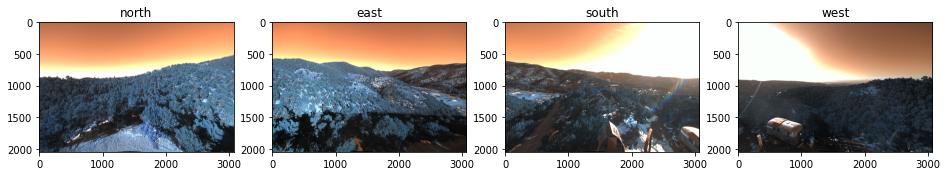

In [5]:
fig, ax = plt.subplots(1,4, figsize=(16,6))
ax[0].imshow(img_north, cmap='gray')
ax[0].set_title('north')
ax[1].imshow(img_east, cmap='gray')
ax[1].set_title('east')
ax[2].imshow(img_south, cmap='gray')
ax[2].set_title('south')
ax[3].imshow(img_west, cmap='gray')
ax[3].set_title('west')
plt.show()

## warp to cylindrical coordinates

In [6]:
print(K)

[[1.22114513e+03 0.00000000e+00 1.43507439e+03]
 [0.00000000e+00 1.20989176e+03 1.03887727e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [7]:
img_north_cyl = pano.cylindricalWarp(img_north.copy(), K)
img_east_cyl = pano.cylindricalWarp(img_east.copy(), K)
img_south_cyl = pano.cylindricalWarp(img_south.copy(), K)
img_west_cyl = pano.cylindricalWarp(img_west.copy(), K)
warp_mask = pano.cylindricalWarp(np.ones(img_north.shape, dtype=np.uint8), K)

#### crop to mask

In [8]:
_, thresh = cv2.threshold(img_north_cyl, 0, 255, cv2.THRESH_BINARY)
thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
x_max_mask = np.max(np.where(np.max(thresh,axis=0)==255))
x_min_mask =  np.min(np.where(np.max(thresh,axis=0)==255))

In [9]:
img_north_cyl = img_north_cyl.copy()[:, x_min_mask:x_max_mask]
img_east_cyl = img_east_cyl.copy()[:, x_min_mask:x_max_mask]
img_south_cyl = img_south_cyl.copy()[:, x_min_mask:x_max_mask]
img_west_cyl = img_west_cyl.copy()[:, x_min_mask:x_max_mask]

#### show warped and cropped images

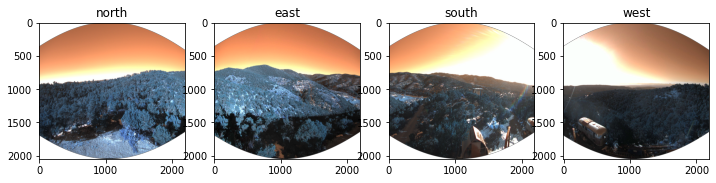

In [10]:
fig, ax = plt.subplots(1,4, figsize=(12,6))
ax[0].imshow(img_north_cyl, cmap='gray')
ax[0].set_title('north')
ax[1].imshow(img_east_cyl, cmap='gray')
ax[1].set_title('east')
ax[2].imshow(img_south_cyl, cmap='gray')
ax[2].set_title('south')
ax[3].imshow(img_west_cyl, cmap='gray')
ax[3].set_title('west')
plt.show()

## composite warped images onto a canvas

In [11]:
### let just line them up for goodness sake!
## working in the 2d domain on the surface of a unit cylinder
img_h, img_w, channels = img_north_cyl.shape

## image overlap in pixels
overlap = 300
h_overlap = ceil(overlap/2)
h_width = ceil(img_w/2)

## Y and X offsets for each image (refinement)
## problem if y_offset > Y_padding
y_padding = 200
offsets = np.array([[100,0],
                    [100,0],
                    [110,0],
                    [100,-50]])

## (refinement) rotations before compositing
## rotations about each image center in degrees
rots = np.array([0, 0, 0, 0])
R = np.array([cv2.getRotationMatrix2D((img_w/2, img_h/2), r, 1) for r in rots])

## make a canvas, add padding to y
canvas = np.zeros((4, img_h + y_padding, img_w * 4 - overlap * 4, channels), dtype=np.uint8)
canvas_h, canvas_w = canvas.shape[1:-1]

## paint in each camera's contribution on the canvas (unrolled cylinder)
## the first image (at the "ends") we will only translate for now. 
## its orientation will be the global reference in terms of rotation
## (see automatic stitching paper section "automatic straightening")
## note that images are not reprojected to cylinder after 2d transformations, so we are introducing distortions here
canvas[0, offsets[0,0]:canvas_h-(y_padding-offsets[0,0]), 0:h_width+h_overlap+0+offsets[0,1]] = img_north_cyl[:, h_width-h_overlap-offsets[0,1]:]
canvas[0, offsets[0,0]:canvas_h-(y_padding-offsets[0,0]), canvas.shape[2]-h_width+h_overlap+offsets[0,1]:] = img_north_cyl[:, :h_width-h_overlap-offsets[0,1]]
canvas[1, offsets[1,0]:canvas_h-(y_padding-offsets[1,0]), h_width-h_overlap+offsets[1,1]:int(1.5*img_w)-h_overlap+offsets[1,1]] = cv2.warpAffine(img_east_cyl, R[1], (img_w, img_h))
canvas[2, offsets[2,0]:canvas_h-(y_padding-offsets[2,0]), int(1.5*img_w)-3*h_overlap+offsets[2,1]:int(2.5*img_w)-3*h_overlap+offsets[2,1]] = cv2.warpAffine(img_south_cyl, R[2], (img_w, img_h))
canvas[3, offsets[3,0]:canvas_h-(y_padding-offsets[3,0]), int(2.5*img_w)-5*h_overlap+offsets[3,1]:int(3.5*img_w)-5*h_overlap+offsets[3,1]] = cv2.warpAffine(img_west_cyl, R[3], (img_w, img_h))

In [12]:
canvas_w

7568

#### write additive blended image

In [13]:
align_only = np.zeros(canvas.shape[1:], dtype=np.uint8)
for i in range(4):
    cv2.imwrite('cylinder_overlap_{}_{}.png'.format(overlap, i), canvas[i])
    align_only = cv2.add(align_only, canvas[i]) 
cv2.imwrite('aligned_only.png', align_only)

True

#### show image placement on canvas

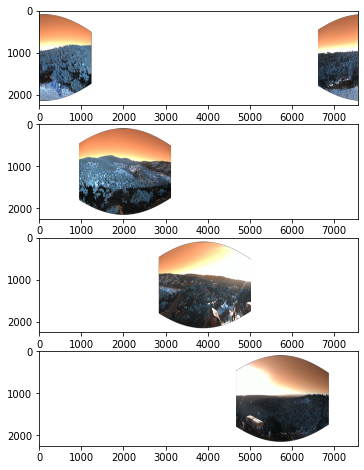

In [14]:
fig, ax = plt.subplots(4,1, figsize=(8,8))
for i in range(4):
    ax[i].imshow(canvas[i])
plt.show()

## linear blending

In [15]:
%%time
## start with a linear blend
## this method is super slow, steps through every pixel
## at least it makes the blending decision at every pixel very clear
## build on this for multi band...?
linear_blend = np.zeros(canvas.shape[1:], dtype=np.float32)
for i in range(int(canvas.shape[1])):
    for j in range(int(canvas.shape[2])):
        layers = []
        for c in range(4):
            values = canvas[c,i,j,:]

            if values.all() == 0:
                continue
            else:
                layers.append(values)

        if len(layers) == 1:
            linear_blend[i,j] = layers[0]
        elif len(layers) == 2:
            linear_blend[i,j] = np.sum(canvas[:,i,j,:], axis=0) / 2
            linear_blend[i,j,-1] = 255
            
linear_blend_8 = np.array(linear_blend, dtype=np.uint8)
cv2.imwrite('linear_blend.png', linear_blend_8)

CPU times: user 5min 2s, sys: 1.42 s, total: 5min 4s
Wall time: 5min 3s


True

In [16]:
test = cv2.imread('cylinder_overlap_300_1.png', cv2.IMREAD_UNCHANGED)

(2248, 7568, 4)


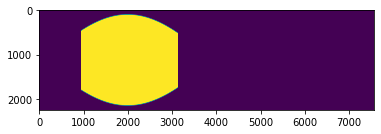

In [17]:
print(test.shape)
plt.imshow(test[:,:,-1])